# Estimating parameters in an ODE system using SciPy

In the following we implement a simple ODE system (the Lotka-Voltera model for a prey-predator population) and try to estimate its parameters using scipy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
%load_ext watermark
%watermark -p numpy,matplotlib,scipy

numpy 1.17.2
matplotlib 3.1.1
scipy 1.1.0


The Lotka-Voltera equations read
\begin{align}
 dy_1/dt &= p_1 y_1 - p_2 y_1 y_2, \\
 dy_2/dt &= p_3 y_1 y_2 - p_4 y_2
\end{align}
where $y_1(t)$ is the number of prey, $y_2(t)$ the number of predators and $p_i$ are positive real parameters.

In [2]:
def lotka_voltera(t, y, p):
    return [
        p[0] * y[0] - p[1] * y[0] * y[1],
        p[2] * y[0] * y[1] - p[3] * y[1]
    ]

We generate some experimental data.

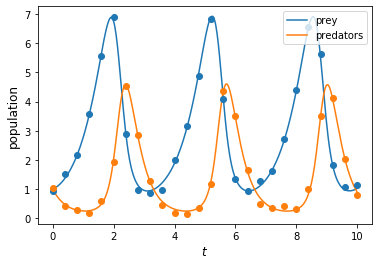

In [3]:
p_true = [1.5, 1, 1, 3]

sol = solve_ivp(
    fun=lambda t, y: lotka_voltera(t, y, p_true),
    y0=[1, 1],
    t_span=(0, 10),
    t_eval=np.linspace(0, 10, 501)
)

# experimental observations every 0.4 time units
t_obs = sol.t[::20]
y_obs = sol.y[:, ::20].copy()
y_obs += 0.1 * np.random.randn(*y_obs.shape)  # iid additive Gaussian noise

plt.plot(sol.t, sol.y.T)
plt.plot(t_obs, y_obs[0], 'C0 o')
plt.plot(t_obs, y_obs[1], 'C1 o')
plt.legend(['prey', 'predators'])
plt.xlabel('$t$')
plt.ylabel('population');

We set up a squared loss by computing the populations for given parameters p and comparing against the experimental data.

In [4]:
def least_squares(p):
    sol = solve_ivp(
        fun=lambda t, y: lotka_voltera(t, y, p),
        y0=[1, 1],
        t_span=(0, 10),
        t_eval=t_obs
    )
    if sol.success:
        return np.sum((sol.y - y_obs) ** 2)
    else:
        print('solve_ivp failed for p =', p)
        return np.inf

least_squares(p_true)

0.49540991626085906

Finally, we minimize this loss using L-BFGS-B (without gradients).

In [5]:
res = minimize(
    least_squares, 
    x0=[1.45, 1, 1, 2.9], # initial guess for p
    bounds=[(0.1, 5), (0.1, 5), (0.1, 5), (0.1, 5)])
res

      fun: 0.8098585024305031
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3239.07645858, 143642.75375104,   5833.55706241, 143194.95458288])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 700
      nit: 24
   status: 2
  success: False
        x: array([1.51045156, 1.01776536, 0.99754222, 2.94966267])

Even when starting close to the true parameters, the found optimum is clearly worse than the true parameters. Also, the optimization fails for certain starting points. This calls for a more sophisticated approach.